# Customer Churn Analysis for a Telecom Provider

### Importing Libraries

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta
import random

In [267]:
# set options to be maximum rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# hide all warnings runtime
import warnings
warnings.filterwarnings('ignore')

# 1. Generating Synthetic Data

### ✅ Dataset 1: Customers Records

In [268]:
fake = Faker()
np.random.seed(42)
random.seed(42)

# Record count
n_customers = 15000

# Helper functions
def generate_plan():
    return random.choices(['Prepaid', 'Postpaid'], weights=[0.4, 0.6])[0]

def generate_monthly_bill():
    base = np.random.normal(50, 15)
    return round(abs(base) + np.random.choice([0, 0, 0, 10, 20], p=[0.7, 0.1, 0.1, 0.05, 0.05]), 2)

def generate_tenure():
    return np.random.randint(1, 60)

def assign_churn(monthly_bill, complaints, resolved_rate, tenure):
    score = 0
    if monthly_bill > 70:
        score += 2
    if complaints >= 3:
        score += 2
    if resolved_rate < 0.5:
        score += 2
    if tenure < 6:
        score += 1
    return 'Y' if score >= 3 else 'N'

def introduce_nulls(series, percent):
    mask = np.random.rand(len(series)) < percent
    return series.mask(mask)

# Generate columns
customer_ids = [f'CUST{i:05d}' for i in range(n_customers)]
plan_type = [generate_plan() for _ in range(n_customers)]
monthly_bills = [generate_monthly_bill() for _ in range(n_customers)]
tenures = [generate_tenure() for _ in range(n_customers)]
complaints = np.random.poisson(1, n_customers).clip(0, 7)
complaints = introduce_nulls(pd.Series(complaints), 0.10)

# Fake support resolution rate for churn scoring logic
fake_resolved_rate = np.random.rand(n_customers)

# Assign churn using business logic
churns = [assign_churn(monthly_bills[i], 0 if pd.isna(complaints[i]) else complaints[i],
                       fake_resolved_rate[i], tenures[i]) for i in range(n_customers)]

# Final dataset
customer_records = pd.DataFrame({
    'CustomerID': customer_ids,
    'PlanType': plan_type,
    'MonthlyBill': monthly_bills,
    'Tenure': tenures,
    'Churn': churns,
    'Complaints': complaints
})

customer_records.to_csv('customer_records.csv', index=False)

### ✅ Dataset 2: Customer Interactions

In [269]:
fake = Faker()
np.random.seed(42)
random.seed(42)

# Record count
n_customers = 15000
n_interactions = 20000

# Customer IDs (reuse, many interactions per customer)
customer_ids = [f'CUST{i:05d}' for i in range(n_customers)]
interaction_customer_ids = np.random.choice(customer_ids, size=n_interactions, replace=True)

# Generate data
interaction_types = np.random.choice(['Call', 'Email', 'Chat'], size=n_interactions, p=[0.5, 0.3, 0.2])
interaction_dates = [fake.date_between(start_date='-1y', end_date='today') for _ in range(n_interactions)]
issue_resolved = np.random.choice(['Y', 'N'], size=n_interactions, p=[0.7, 0.3])

# Create DataFrame
customer_interactions = pd.DataFrame({
    'CustomerID': interaction_customer_ids,
    'InteractionDate': interaction_dates,
    'InteractionType': interaction_types,
    'IssueResolved': issue_resolved
})

# Inject nulls according to project spec
customer_interactions.loc[
    customer_interactions.sample(frac=0.165, random_state=42).index, 'InteractionDate'] = np.nan

customer_interactions.loc[
    customer_interactions.sample(frac=0.165, random_state=43).index, 'InteractionType'] = np.nan

customer_interactions.loc[
    customer_interactions.sample(frac=0.2075, random_state=44).index, 'IssueResolved'] = np.nan


customer_interactions.to_csv('customer_interactions.csv', index=False)

### ✅ Dataset 3: Customers Demographics

In [270]:
np.random.seed(42)
random.seed(42)

# Records
n_customers = 15000
customer_ids = [f'CUST{i:05d}' for i in range(n_customers)]

# Define values
regions = ['North', 'South', 'East', 'West', 'Central']
device_types = ['Android', 'iPhone', 'Keypad', 'Laptop']

# Generate data
ages = np.random.randint(18, 70, size=n_customers)
regions_data = np.random.choice(regions, size=n_customers)
device_data = np.random.choice(device_types, size=n_customers, p=[0.4, 0.3, 0.2, 0.1])

# Inject ~7% nulls in Region
regions_data = pd.Series(regions_data)
regions_data.loc[regions_data.sample(frac=0.07, random_state=45).index] = np.nan

# Final DataFrame
customer_demographics = pd.DataFrame({
    'CustomerID': customer_ids,
    'Age': ages,
    'Region': regions_data,
    'DeviceType': device_data
})

customer_demographics.to_csv('customer_demographics.csv', index=False)

In [271]:
customer_records = pd.read_csv("customer_records.csv")
customer_interactions = pd.read_csv("customer_interactions.csv")
customer_demographics = pd.read_csv("customer_demographics.csv")

In [272]:
# Group interaction data → so each customer has one row → then merge.
# This avoids row duplication and fake nulls.

interaction_stats = customer_interactions.groupby('CustomerID').agg({
    'InteractionType': 'count',
    'IssueResolved': lambda x: (x =='Y').mean(),
    'InteractionDate': 'count'
}).rename(columns={
    'InteractionType' :'TotalInteractions',
    'IssueResolved' : 'IssueResolvedRate',
    'InteractionDate' : 'ValidInteractionDates'
}).reset_index()

### **Joining All Datasets**

In [273]:
df_pre = customer_records.merge(customer_demographics, on='CustomerID', how='left')
df = df_pre.merge(interaction_stats, on='CustomerID', how='left')

# 🔍 Step 2: Data Preprocessing & Feature Engineering

In [274]:
df.describe(include='object')

,CustomerID,PlanType,Churn,Region,DeviceType
count,15000,15000,15000,13950,15000
unique,15000,2,2,5,4
top,CUST00000,Postpaid,N,West,Android
freq,1,8991,12932,2863,6027


In [275]:
df.describe()

,MonthlyBill,Tenure,Complaints,Age,TotalInteractions,IssueResolvedRate,ValidInteractionDates
count,15000.000000,15000.000000,13536.000000,15000.000000,11023.000000,11023.000000,11023.000000
mean,51.728883,30.126267,0.999852,43.452667,1.515014,0.553941,1.515014
std,15.562818,17.067361,0.992100,14.910732,0.957226,0.415846,0.960727
min,0.020000,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,41.110000,16.000000,0.000000,31.000000,1.000000,0.000000,1.000000
50%,51.310000,30.000000,1.000000,43.000000,1.000000,0.500000,1.000000
75%,61.990000,45.000000,2.000000,56.000000,2.000000,1.000000,2.000000
max,117.190000,59.000000,7.000000,69.000000,8.000000,1.000000,8.000000


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             15000 non-null  object 
 1   PlanType               15000 non-null  object 
 2   MonthlyBill            15000 non-null  float64
 3   Tenure                 15000 non-null  int64  
 4   Churn                  15000 non-null  object 
 5   Complaints             13536 non-null  float64
 6   Age                    15000 non-null  int64  
 7   Region                 13950 non-null  object 
 8   DeviceType             15000 non-null  object 
 9   TotalInteractions      11023 non-null  float64
 10  IssueResolvedRate      11023 non-null  float64
 11  ValidInteractionDates  11023 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 1.4+ MB


In [277]:
df.shape

(15000, 12)

## Handling Missing Values

In [278]:
df.isnull().sum() / len(df) *100

CustomerID                0.000000
PlanType                  0.000000
MonthlyBill               0.000000
Tenure                    0.000000
Churn                     0.000000
Complaints                9.760000
Age                       0.000000
Region                    7.000000
DeviceType                0.000000
TotalInteractions        26.513333
IssueResolvedRate        26.513333
ValidInteractionDates    26.513333
dtype: float64

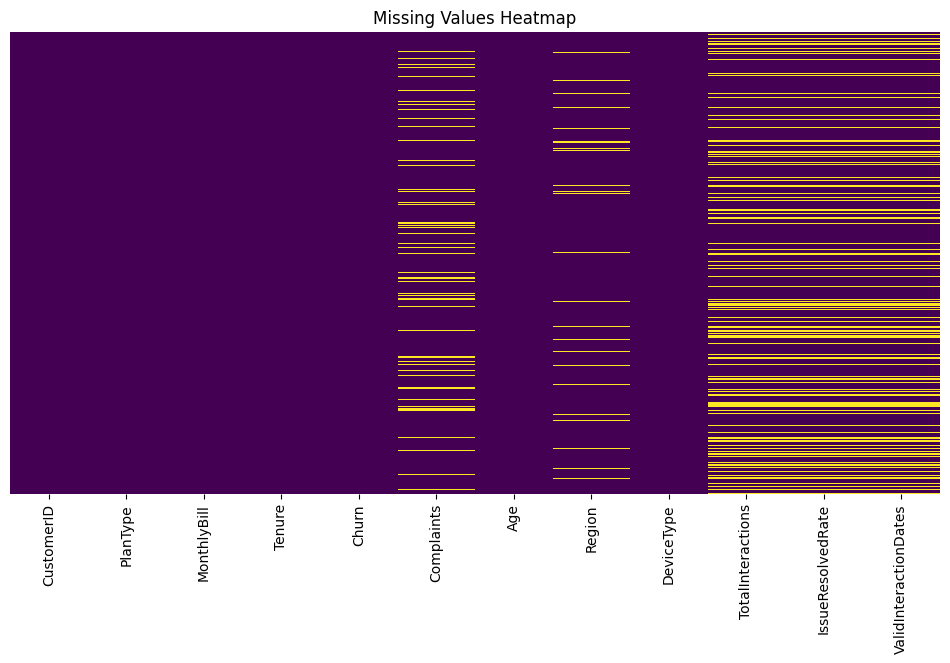

In [279]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [280]:
df['Complaints'].describe()

count    13536.000000
mean         0.999852
std          0.992100
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: Complaints, dtype: float64

In [281]:
df['Complaints'].mean()

np.float64(0.9998522458628841)

In [282]:
df['Complaints'].skew()

np.float64(0.9705707473393282)

In [283]:
#Filling Missing Values with Median
df['Complaints'].fillna(df['Complaints'].median(), inplace=True)

In [284]:
#2. Region
df['Region'].describe()

count     13950
unique        5
top        West
freq       2863
Name: Region, dtype: object

In [285]:
# Filling it Mode
df['Region'].fillna(df['Region'].mode()[0], inplace=True)

In [286]:
# Filling with 0, because missing here means no interactions ever happened

df['TotalInteractions'].fillna(0, inplace=True)

In [287]:
# Filling with 0, no resolution beacuse no contact

df['IssueResolvedRate'].fillna(0, inplace=True)

In [288]:
# Filling with 0, No Interaction = 0 valid dates

df['ValidInteractionDates'].fillna(0, inplace=True)

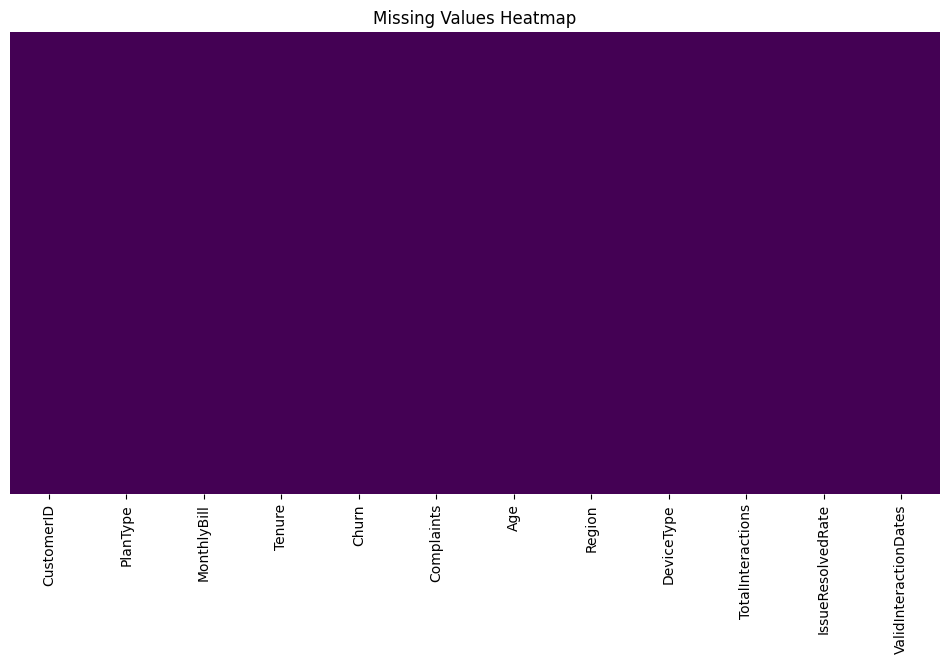

In [289]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

## Handling Outliers

In [290]:
def check_outliers(df):
    outlier_summary = {}

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        outlier_summary[col] = {
            "count": len(outliers),
            "percent": round(100 * len(outliers) / len(df), 2)
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by="percent", ascending=False)

In [291]:
outlier_report = check_outliers(df)
print(outlier_report)

                        count  percent
Complaints             1078.0     7.19
MonthlyBill             135.0     0.90
TotalInteractions        16.0     0.11
ValidInteractionDates    11.0     0.07
Tenure                    0.0     0.00
Age                       0.0     0.00
IssueResolvedRate         0.0     0.00


In [292]:
df.describe()

,MonthlyBill,Tenure,Complaints,Age,TotalInteractions,IssueResolvedRate,ValidInteractionDates
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,51.728883,30.126267,0.999867,43.452667,1.113333,0.407072,1.113333
std,15.562818,17.067361,0.942440,14.910732,1.058567,0.432280,1.060895
min,0.020000,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,41.110000,16.000000,0.000000,31.000000,0.000000,0.000000,0.000000
50%,51.310000,30.000000,1.000000,43.000000,1.000000,0.333333,1.000000
75%,61.990000,45.000000,1.000000,56.000000,2.000000,1.000000,2.000000
max,117.190000,59.000000,7.000000,69.000000,8.000000,1.000000,8.000000


# Step 3: EDA

In [293]:
pd.crosstab(df['PlanType'], df['Churn'], normalize='index')

Churn,N,Y
PlanType,,
Postpaid,0.863864,0.136136
Prepaid,0.859544,0.140456


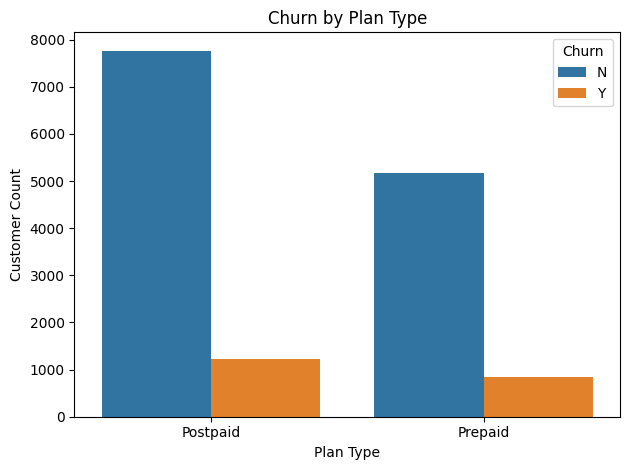

In [294]:
sns.countplot(data=df, x='PlanType', hue='Churn')
plt.title('Churn by Plan Type')
plt.xlabel('Plan Type')
plt.ylabel('Customer Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [295]:
df['ComplaintsGroup'] = pd.cut(df['Complaints'], bins=[-1, 0, 1, 3, 7], labels=['None', 'Low', 'Medium', 'High'])

In [296]:
# Insight 1
pd.crosstab(df['ComplaintsGroup'], df['Churn'], normalize='index')

Churn,N,Y
ComplaintsGroup,,
None,0.900161,0.099839
Low,0.896632,0.103368
Medium,0.771420,0.228580
High,0.398230,0.601770


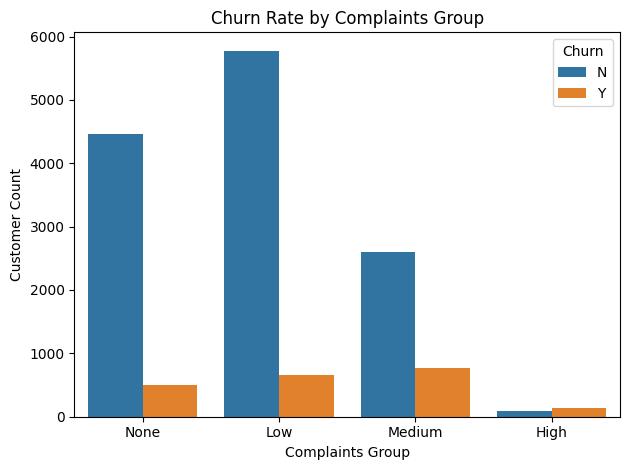

In [297]:
sns.countplot(data=df, x='ComplaintsGroup', hue='Churn', order=['None', 'Low', 'Medium', 'High'])
plt.title('Churn Rate by Complaints Group')
plt.xlabel('Complaints Group')
plt.ylabel('Customer Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [298]:
df['BillGroup'] = pd.cut(df['MonthlyBill'], bins=[0,30, 60, 90, np.inf], labels=['Low', 'Mid', 'High', 'Very High'])

In [299]:
# Insight 2
pd.crosstab(df['BillGroup'], df['Churn'], normalize='index')

Churn,N,Y
BillGroup,,
Low,0.936041,0.063959
Mid,0.918525,0.081475
High,0.727743,0.272257
Very High,0.479675,0.520325


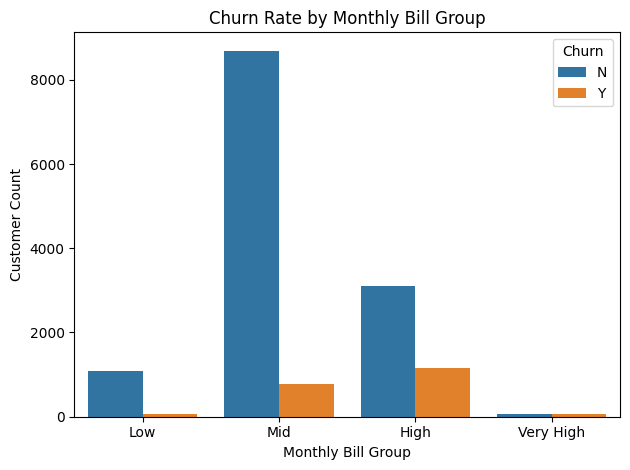

In [300]:
sns.countplot(data=df, x='BillGroup', hue='Churn', order=['Low', 'Mid', 'High', 'Very High'])
plt.title('Churn Rate by Monthly Bill Group')
plt.xlabel('Monthly Bill Group')
plt.ylabel('Customer Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [301]:
pd.crosstab(df['Region'], df['Churn'], normalize='index')

Churn,N,Y
Region,,
Central,0.865736,0.134264
East,0.863552,0.136448
North,0.862989,0.137011
South,0.858741,0.141259
West,0.860465,0.139535


In [302]:
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 6, 12, 24, 60, np.inf], labels=['<6M', '6-12M', '1-2Y', '2-5Y', '5Y+'])

In [303]:
# Insight 3
pd.crosstab(df['TenureGroup'], df['Churn'], normalize='index')

Churn,N,Y
TenureGroup,,
<6M,0.486012,0.513988
6-12M,0.896104,0.103896
1-2Y,0.911887,0.088113
2-5Y,0.904156,0.095844


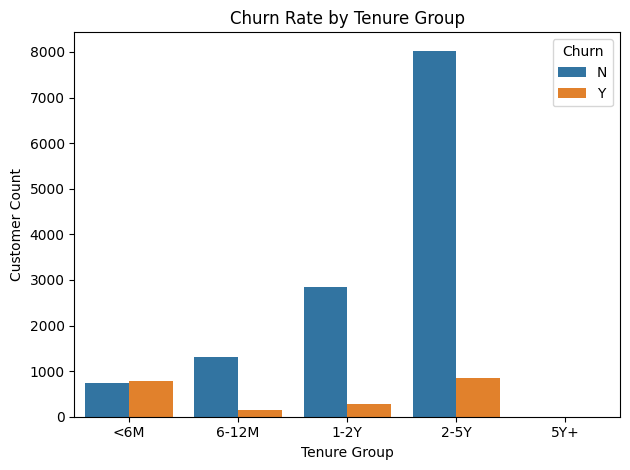

In [304]:
sns.countplot(data=df, x='TenureGroup', hue='Churn', order=['<6M', '6-12M', '1-2Y', '2-5Y', '5Y+'])
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Customer Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [305]:
pd.crosstab(df['DeviceType'], df['Churn'], normalize='index')

Churn,N,Y
DeviceType,,
Android,0.858470,0.141530
Keypad,0.871899,0.128101
Laptop,0.866756,0.133244
iPhone,0.859155,0.140845


### Correlation Heatmap

In [306]:
df.corr(numeric_only=True)

,MonthlyBill,Tenure,Complaints,Age,TotalInteractions,IssueResolvedRate,ValidInteractionDates
MonthlyBill,1.000000,-0.005035,-0.001116,-0.002748,0.003086,0.006014,-0.004262
Tenure,-0.005035,1.000000,-0.003518,0.007589,-0.000180,-0.007882,-0.002886
Complaints,-0.001116,-0.003518,1.000000,-0.007307,-0.004396,-0.013810,-0.002586
Age,-0.002748,0.007589,-0.007307,1.000000,-0.000218,0.012024,-0.001410
TotalInteractions,0.003086,-0.000180,-0.004396,-0.000218,1.000000,0.361013,0.836386
IssueResolvedRate,0.006014,-0.007882,-0.013810,0.012024,0.361013,1.000000,0.360651
ValidInteractionDates,-0.004262,-0.002886,-0.002586,-0.001410,0.836386,0.360651,1.000000


In [307]:
df['ChurnNumeric']= df['Churn'].map({'Y': 1, 'N': 0})

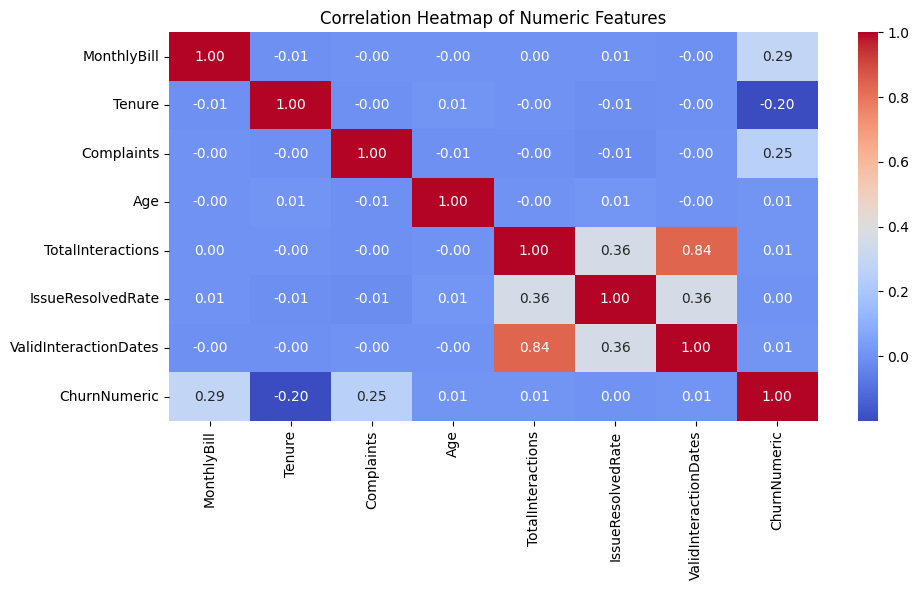

In [308]:
# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

<Axes: xlabel='timeline'>

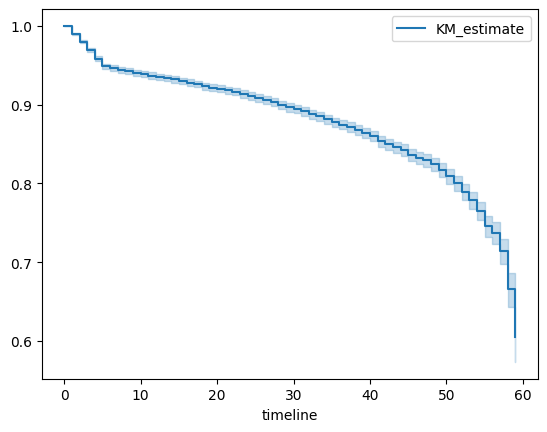

In [344]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(durations=df['Tenure'], event_observed=(df['Churn'] == 'Y'))
kmf.plot()

# Chi Square Test

In [309]:
# Import
from scipy.stats import chi2_contingency

In [310]:
# P-value Insight 
table = pd.crosstab(df['BillGroup'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 3.7013020838557054e-239


In [311]:
table = pd.crosstab(df['IssueResolvedRate'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.6459560572026792


In [312]:
table = pd.crosstab(df['ValidInteractionDates'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.6060872075210678


In [313]:
table = pd.crosstab(df['TotalInteractions'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.7339720378240504


In [314]:
table = pd.crosstab(df['DeviceType'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.30203126960882465


In [315]:
# Close but not a P-value Insight
table = pd.crosstab(df['Age'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.08501674175777717


In [316]:
# P-value Insight
table = pd.crosstab(df['ComplaintsGroup'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 4.713570023281245e-166


In [317]:
table = pd.crosstab(df['PlanType'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.4667221504104978


In [318]:
# P-value Insight
table = pd.crosstab(df['TenureGroup'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 0.0


In [319]:
df['UnresolvedComplaints'] = (df['Complaints'] > 1) & (df['IssueResolvedRate'] ==0)

In [320]:
# P-value Insight
table = pd.crosstab(df['UnresolvedComplaints'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square p-value:", p)

Chi-square p-value: 5.679936381725771e-44


## Optional

### Logistic Regression

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CustomerID             15000 non-null  object  
 1   PlanType               15000 non-null  object  
 2   MonthlyBill            15000 non-null  float64 
 3   Tenure                 15000 non-null  int64   
 4   Churn                  15000 non-null  object  
 5   Complaints             15000 non-null  float64 
 6   Age                    15000 non-null  int64   
 7   Region                 15000 non-null  object  
 8   DeviceType             15000 non-null  object  
 9   TotalInteractions      15000 non-null  float64 
 10  IssueResolvedRate      15000 non-null  float64 
 11  ValidInteractionDates  15000 non-null  float64 
 12  ComplaintsGroup        15000 non-null  category
 13  BillGroup              15000 non-null  category
 14  TenureGroup            15000 non-null 

## Feature Engineering for Model

In [322]:
df['BillToTenure'] = df['MonthlyBill'] / (df['Tenure'] + 1)  # +1 to avoid division by zero

In [323]:
df['ComplaintsPerMonth'] = df['Complaints'] / (df['Tenure'] + 1)

In [324]:
df['UnresolvedRate'] = 1 - df['IssueResolvedRate']  # assuming 0 to 1 scale

In [325]:
df['InteractionsPerMonth'] = df['TotalInteractions'] / (df['Tenure'] + 1)

In [326]:
# Cross-Features (Interaction Terms)
df['Complaint*Bill'] = df['Complaints'] * df['MonthlyBill']

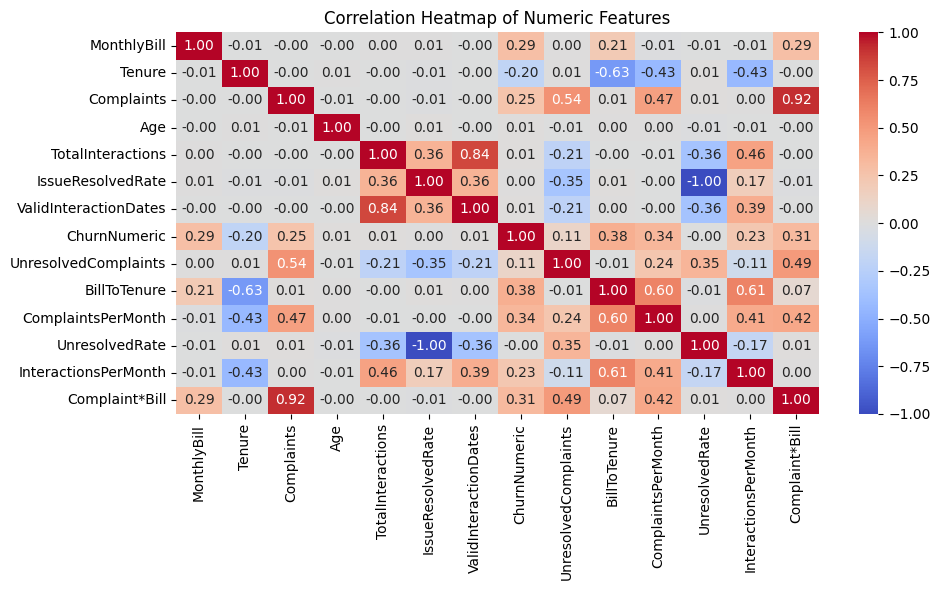

In [327]:
# Correltion Heatmap No. 2

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

In [328]:
df_encoded = df[['PlanType', 'MonthlyBill', 'Tenure',
       'Complaints', 'Age', 'Region', 'DeviceType', 'TotalInteractions',
       'IssueResolvedRate', 'ValidInteractionDates', 'Churn',
       'UnresolvedComplaints', 'BillToTenure', 'ComplaintsPerMonth', 
       'UnresolvedRate','InteractionsPerMonth','Complaint*Bill']]

In [329]:
df_encoded = pd.get_dummies(df_encoded, columns=['PlanType', 'DeviceType', 'Region'], drop_first=True, dtype=int)

In [330]:
df_encoded.head()

,MonthlyBill,Tenure,Complaints,Age,TotalInteractions,IssueResolvedRate,ValidInteractionDates,Churn,UnresolvedComplaints,BillToTenure,ComplaintsPerMonth,UnresolvedRate,InteractionsPerMonth,Complaint*Bill,PlanType_Prepaid,DeviceType_Keypad,DeviceType_Laptop,DeviceType_iPhone,Region_East,Region_North,Region_South,Region_West
0,57.45,6,1.0,56,0.0,0.000000,0.0,N,False,8.207143,0.142857,1.000000,0.000000,57.45,0,0,0,1,0,0,0,1
1,47.93,43,1.0,69,2.0,0.333333,3.0,N,False,1.089318,0.022727,0.666667,0.045455,47.93,1,0,0,0,0,0,0,0
2,46.49,49,1.0,46,2.0,1.000000,1.0,N,False,0.929800,0.020000,0.000000,0.040000,46.49,1,1,0,0,0,0,0,1
3,46.49,9,1.0,32,0.0,0.000000,0.0,N,False,4.649000,0.100000,1.000000,0.000000,46.49,1,0,0,1,0,0,0,0
4,73.69,37,0.0,60,1.0,1.000000,1.0,N,False,1.939211,0.000000,0.000000,0.026316,0.00,0,0,1,0,0,1,0,0


In [331]:
# Model Selection

from sklearn.model_selection import train_test_split

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn'].map({'N': 0, 'Y': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [332]:
# Checking Data Imbalance
y.value_counts()

Churn
0    12932
1     2068
Name: count, dtype: int64

In [333]:
# Before Smote
y.value_counts(normalize=True)

Churn
0    0.862133
1    0.137867
Name: proportion, dtype: float64

In [334]:
# Balncing the Data

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_res, y_res = smote.fit_resample(X_train, y_train)

In [335]:
#Checking SMOTE worked or not

y_res.value_counts(normalize=True)

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [336]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_res, y_res)

LogisticRegression(max_iter=1000)

Precision: 0.4014084507042254
Recall: 0.5516129032258065
F1-Score: 0.46467391304347827
ROC AUC : 0.8437441802460924
Confusion Matrix: [[3370  510]
 [ 278  342]]


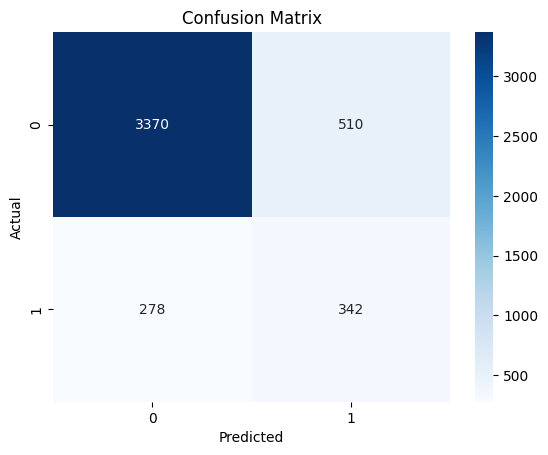

In [337]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

y_pred  = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)

# Plot it
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

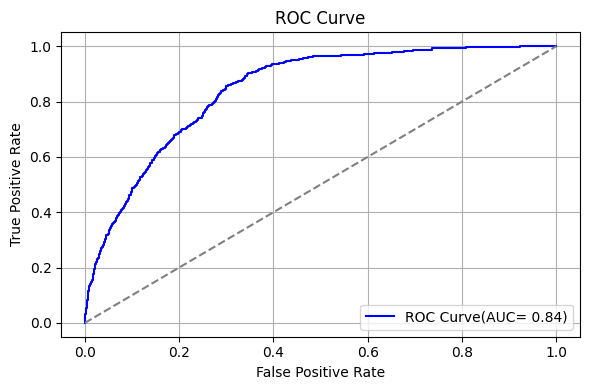

In [338]:
# ROC AUC Curve

from sklearn.metrics import roc_curve, roc_auc_score

y_proba = lr.predict_proba(X_test)[:, 1]

# GET ROC Curve Values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve(AUC= {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

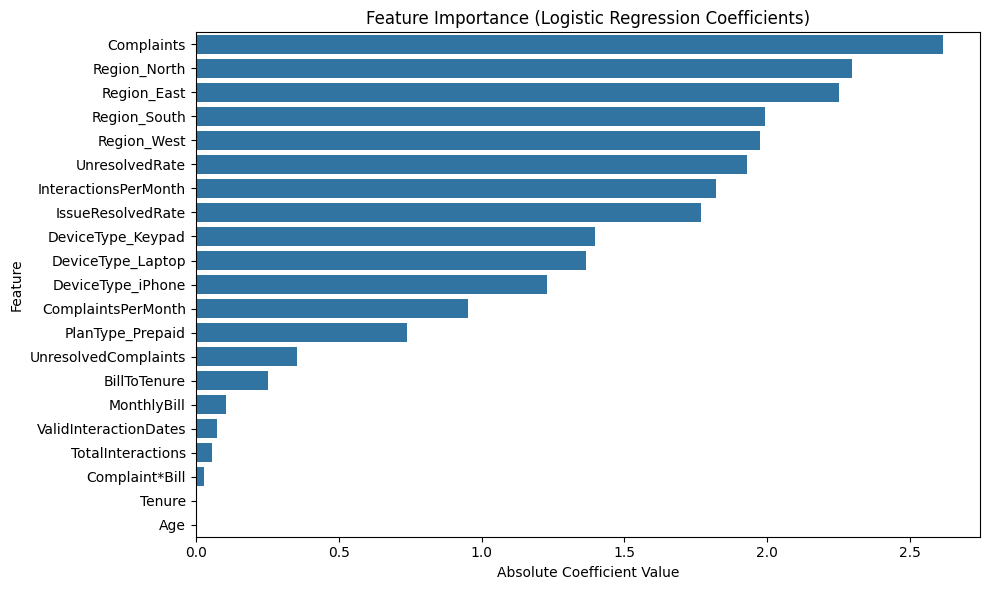

In [339]:
# Plot feature importance for logistic regression (using absolute value of coefficients)
importance = pd.Series(abs(lr.coef_[0]), index=X_res.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()